Кирбаба Денис Дмитриевич, факультет СУиР, группа R3238
# Распознавание активности человека на основе данных с мобильных сенсоров

## Импорт библиотек
Первым делом импортируем необходимые библиотеки для работы с данными:

In [124]:
# import the necessary packages
import os
import numpy as np
import pandas as pd
import argparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

## Функции считывания  данных и загрузки и сохранения данных в переменные
Переменные, в которые сохраняются данные:
* `train_X`: признаки, используемые для обучения модели
* `train_y`: метки, используемые для обучения модели
* `test_X`: признаки, используемые для проверки модели
* `test_y`: метки, используемые для проверки модели

In [125]:
def read_data(path, filename):
    # reading a set of preprocessed data
    return pd.read_csv(os.path.join(path, filename))

def load_dataset(label_dict, path, train_filename, test_filename):
    # load and save dataset
    train_X = read_data(path, train_filename).values[:, :-2]
    train_y = read_data(path, train_filename)['Activity']
    # substituting each value in a Series (train_y) with another value, derived from dict (label_dict)
    train_y = train_y.map(label_dict).values
    test_X = read_data(path, test_filename).values[:, :-2]
    test_y = read_data(path, test_filename)
    test_y = test_y['Activity'].map(label_dict).values
    return train_X, test_X, train_y, test_y

## Ввод аргументов

Парсер был удобен мне при вводе аргументов в виде командной строки для построения и тестирования моделей при различных входных параметрах. Однако далее будет удобнее вводить аргументы другим образом.

In [126]:
# entering arguments using command line arguments

'''
# construct the argument parse and parse the arguments

ap = argparse.ArgumentParser()
ap.add_argument("-p", "--path", required=True, help="path to input dataset")
ap.add_argument("-k", "--neighbors", type=int, default=1, help="# of nearest neighbors for classification, "
                                                               "needed in case of using k-NN algorithm")
ap.add_argument("-j", "--jobs", type=int, default=-1, help="# of jobs for K-NN distance "
                                                           "(-1 uses all available cores),"
                                                           "needed in case of using k-NN algorithm")
ap.add_argument("-c", "--regularization_param", type=int, default=1, help="The strength of the regularization "
                                                                          "is inversely proportional to C. "
                                                                          "Must be strictly positive,"
                                                                          "needed in case of using SVC algorithm")
ap.add_argument("-ker", "--kernel_type", type=str, default="rbf", help="Specifies the kernel type to be used in "
                                                                       "the algorithm. It must be one of ‘linear’,"
                                                                       "‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’."
                                                                       "needed in case of using SVC algorithm ")
ap.add_argument("-g", "--gamma", type=str, default="scale", help="Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’."
                                                                 "It must be one of ‘scale’, ‘auto’"
                                                                 "needed in case of using SVC algorithm ")
args = vars(ap.parse_args())
'''

# another way of entering arguments

# files destinations
path = "C:\denFiles\git\introduction-to-ai\human activity recognition"
trainFilename = "train.csv"
testFilename = "test.csv"

# arrays of argument values
k_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13 ,14 ,15]
c_param = [0.5, 1, 1.5, 2, 2.5]
kernel_type = ['poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']

## Загружаем данные

In [127]:
# grab the dataset
label_dict = {'WALKING': 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2, 'SITTING': 3, 'STANDING': 4, 'LAYING': 5}
train_X, test_X, train_y, test_y = load_dataset(label_dict, path, trainFilename, testFilename)

## Выбор моделей

Я использовал метод опорных векторов и метод k-ближайших соседей. Так как оба алгоритма используются для классификации объектов.

Основная идея метода опорных векторов — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с наибольшим зазором в этом пространстве. Две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, создающая наибольшее расстояние до двух параллельных гиперплоскостей. Алгоритм основан на допущении, что чем больше разница или расстояние между этими параллельными гиперплоскостями, тем меньше будет средняя ошибка классификатора.

Основная идея метода k-ближайших соседей — объект присваивается тому классу, который является наиболее распространённым среди k соседей данного элемента, классы которых уже известны.

## Обучение и оценка модели k-NN

Рассмотрим результаты классификации при различных значениях параметра k (значения из массива k_neighbors)

Для оценки работы алгоритма будем использовать метод score, который возвращает среднюю точность по представленным тестовым данным и меткам

Text(0, 0.5, 'score')

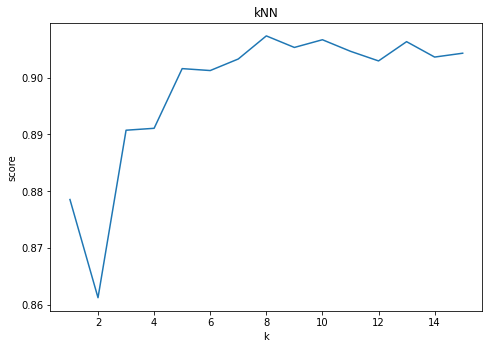

In [128]:
# array for storing the results of method score
kNN_score = []
# array for storing result of method predict from model with coefficient at which the highest efficiency was observed
kNN_yhat = []

best_score = -1
# pass through all k coefficients
for i in k_neighbors:
    model = KNeighborsClassifier(i)
    model.fit(train_X, train_y)
    cur_score = model.score(test_X, test_y)
    kNN_score.append(cur_score)

    # finding kNN_yhat
    if cur_score > best_score:
        kNN_yhat = model.predict(test_X)
        best_score = cur_score

# build a graph of the dependence of the score value on k value
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(k_neighbors, kNN_score)
ax.set_title("kNN")
ax.set_xlabel("k")
ax.set_ylabel("score")

Как мы видим наиболее эффективная классификация происходит при значении k = 8.
Полученное значение является средним в рассматриваемом нами диапазоне [1, 15].

Это вполне ожидаемо, так как если значение параметра мало, то возникает эффект переобучения, когда решение по классификации принимается на основе малого числа примеров и имеет низкую значимость (если k = 1, то алгоритм будет просто присваивать любому новому наблюдению метку класса ближайшего объекта).

Напротив, если значение параметра слишком велико, то в процессе классификации принимает участие много объектов, относящихся к разным классам. Такая классификация оказывается слишком грубой и плохо отражает локальные особенности набора данных.


## Обучение и оценка модели SVC

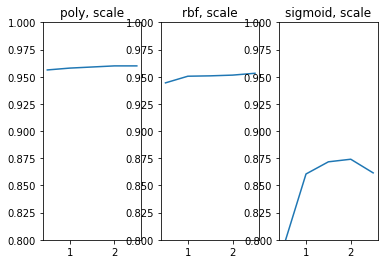

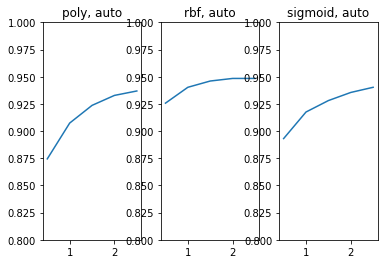

In [129]:
# arrays for storing the results of method score
SVC_score = np.ones((len(kernel_type), len(gamma), len(c_param)))
# array for storing result of method predict from model with (C, kernel_type, gamma) at which the highest efficiency was observed
SVC_yhat = []

best_score = -1
# pass through all kernel types
for i in range(len(kernel_type)):
    # pass through all gammas
    for j in range(len(gamma)):
        # pass through all c parameters
        for k in range(len(c_param)):
            model = SVC(C=c_param[k], kernel=kernel_type[i], gamma=gamma[j])
            model.fit(train_X, train_y)
            cur_score = model.score(test_X, test_y)
            SVC_score[i, j, k] = cur_score

            # finding SVC_yhat
            if cur_score > best_score:
                SVC_yhat = model.predict(test_X)
                best_score = cur_score

# build a graphs of the dependence of the score value on c value
%matplotlib inline
fig1, ax1 = plt.subplots(1, 3)
fig2, ax2 = plt.subplots(1, 3)
ax = [ax1, ax2]

# pass through all kernel types
for i in range(len(kernel_type)):
    for j in range(len(ax)):
        ax[j][i].set_ylim([0.8, 1])
        ax[j][i].plot(c_param, SVC_score[i, j])
        ax[j][i].set_title(kernel_type[i]+', '+ gamma[j])

Наиболее эффективная классификация наблюдается при следующих параметрах модели:
* С = 2
* ядро - полиномиальная функция 3-порядка
* значение gamma = 1 / (n_features * X.var()), где n_features = 561, X.var() - дисперсия

Параметр C - обеспечивает "гладкость" и точность алгоритма, чем больше С, тем точнее классификация.

Gamma – параметр алгоритма определяющий насколько далеко каждый из элементов в наборе данных имеет влияние при определении гиперплоскости. Чем ниже gamma, тем больше элементов принимают участие в выборе линии плоскости.

Kernel - задает тип ядра, который будет использоваться в алгоритме.


## Сравнение моделей SVC и k-NN

In [130]:
# k-NN report
print("k-NN report")
print(classification_report(test_y, kNN_yhat, target_names=label_dict.keys()))

# SVC report
print("SVC report")
print(classification_report(test_y, SVC_yhat, target_names=label_dict.keys()))

k-NN report
                    precision    recall  f1-score   support

           WALKING       0.84      0.98      0.90       496
  WALKING_UPSTAIRS       0.90      0.90      0.90       471
WALKING_DOWNSTAIRS       0.96      0.78      0.86       420
           SITTING       0.89      0.86      0.87       491
          STANDING       0.88      0.90      0.89       532
            LAYING       1.00      0.99      1.00       537

          accuracy                           0.91      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.91      0.91      0.91      2947

SVC report
                    precision    recall  f1-score   support

           WALKING       0.95      0.99      0.97       496
  WALKING_UPSTAIRS       0.95      0.96      0.95       471
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
           SITTING       0.97      0.89      0.93       491
          STANDING       0.91      0.98      0.94       532
            L

Отчет о классификации используется для измерения качества прогнозов алгоритма классификации.

В отчете показаны основные показатели классификации: precision, recall, f1-score и support для каждого класса. Метрики рассчитываются с использованием TN, TP, FN, FP. Есть четыре способа проверить правильность прогнозов:

* TN / True Negative: когда случай был отрицательным и прогноз был отрицательным
* TP / True Positive: когда случай был положительным и предсказал положительным
* FN / False Negative: когда случай был положительным, но прогноз был отрицательным
* FP / False Positive результат: когда случай был отрицательным, но прогноз был положительным

Precision - точность положительных предсказаний

Precision = TP / (TP + FP)

Recall - доля правильно идентифицированных положительных результатов.

Recall = TP / (TP + FN)

f1-score - среднее гармоническое от precision и recall, так что наилучшая оценка составляет 1,0, а наихудшая - 0,0.

F1 Score = 2 * (Recall * Precision) / (Recall + Precision)

support - это количество случаев появления данного класса в наборе данных


## Вывод

Максимально точный классификатор получился с помощью использования метода опорных векторов с параметрами (C = 2, kernel - полиномиальная функция 3 порядка, gamma = 1 / (n_features * X.var())).

Значения precision, recall и f1-score равны 0.96